### Source
The SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. From 2005-2016, the SAT had three sections, each of which was worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets:
* [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
* [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school, including race, income, gender, school year, and language (% english learned language)
* [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
* [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
* [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* [Directory](https://data.cityofnewyork.us/Education/DOE-High-School-Directory-2014-2015/n3p6-zve2) - NYC High Schools, including name, borugh, grade span
* [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school


In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
# read each file into a pandas dataframe 
# then store all of the dataframes in a dictionary

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"]
data = {}
for file_name in data_files:
    df = pd.read_csv(file_name)
    key = file_name.split('.')[0]
    data[key] = df
    
# Survey data is tab-separated with Windows 1252 encoding
all_survey = pd.read_csv('survey_all.txt', delimiter="\t", encoding="windows-1252")
d75_survey = pd.read_csv('survey_d75.txt', delimiter="\t", encoding="windows-1252")
survey = pd.concat([all_survey, d75_survey], axis=0) # added District 75 to the survey data

### Prepare the data

I cleaned and prepared the data sets, which include a District Borough Number (DBN) column. Each DBN value is a unique identifier for every high school in New York City.  

Some data sets, like class_size and demographics, had duplicate DBN values. For example, class_size had a separate row for each class within each highschool. I condensed these data sets so that each value in the DBN column is unique in order to be able to combine them. For example, we caculated the average over all the classes within each highschool.

#### Prepare the SAT results data

Find the average Standard Aptitude Test (SAT) scores for each high school.

In [3]:
# convert the scores from a string to numeric data type
score_cols = data['sat_results'].columns[3:]
for col_name in score_cols:
    data['sat_results'][col_name] = pd.to_numeric(data['sat_results'][col_name], errors="coerce")

# fill the null values with the column average
col_means = data['sat_results'].mean()
data['sat_results'] = data['sat_results'].fillna(col_means)
    
# create a sat_score column with the total score
data['sat_results']['sat_score'] = data['sat_results'][score_cols].apply(np.sum, axis=1)
data['sat_results'].tail(3)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score
475,79M645,SCHOOL FOR COOPERATIVE TECHNICAL EDUCATION,s,400.850356,413.368171,393.985748,1208.204276
476,79Q950,GED PLUS s CITYWIDE,8,496.000000,400.000000,426.000000,1322.000000
477,79X490,PHOENIX ACADEMY,9,367.000000,370.000000,360.000000,1097.000000


#### Prepare the demographics data

We only want to select rows where schoolyear is 20112012. This will give us the most recent year of data, and also match our SAT results data.

In [5]:
# select rows where schoolyear is 20112012
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]
data['demographics'].head(3)

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3


#### Prepare the class size data

DBN is a unique ID for each school, but, unlike the other data sets, class_size doesn't have that column. It does, however, have the CSD and SCHOOL CODE columns, which combine to make the unique DBN for each school.  
With a unique DBN for each school, we can then group by DBN and find the average of the columns with numeric data types, including the average class size column.

In [6]:
def zfill2(integer):
    return(str(integer).zfill(2)) # left filled with ASCII '0' digits to make a string of length 2

In [7]:
# fill the string values in the 'CSD' column with a zero in the front if they are only length 1
col_names = data['class_size'].columns
data['class_size']['padded_csd'] = data["class_size"]["CSD"].apply(zfill2)

# create 'DBN' column using the values in the 'CSD' and 'SCHOOL CODE' columns
if 'SCHOOL CODE' in data['class_size']: # skip if code cell has already run
    data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']
    data['class_size'] = data['class_size'][col_names.insert(0,'DBN')]

# calculate the average class size for each high school
if 'GRADE ' in data['class_size']: # skip if code cell has already run
    class_size = data['class_size']
    class_size = class_size[class_size['GRADE '] == '09-12'] # grades 09-12 only
    class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED'] # general education only
    grouped = class_size.groupby('DBN') # group by high school
    class_size = grouped.agg(np.mean) # calculate average class size
    class_size.reset_index(inplace=True) # reset the index to make 'DBN' a column again
    data['class_size'] = class_size # assign this dataframe back to the data dictionary

# print the class_size data
data['class_size'].head(3)

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0,4.0,22.564286,18.5,26.571429,NaN
1,01M332,1,46.0,2.0,22.000000,21.0,23.500000,NaN
2,01M378,1,33.0,1.0,33.000000,33.0,33.000000,NaN


#### Prepare the high school directory data

In [8]:
def extract_latitude(string):
    #input: string, which must include '(lat, long)' e.g. '(-30, 170)'
    regex = "\(.+\)" # everything between the parentheses
    coordinates = re.findall(regex, string)[0] # e.g. return '(-30, 170)'
    latitude = coordinates.split(',')[0].replace('(','') # e.g. '-30'
    return latitude

In [9]:
def extract_longitude(string):
    #input: string, which must include '(lat, long)' e.g. '(-30, 170)'
    regex = "\(.+\)" # everything between the parentheses
    coordinates = re.findall(regex, string)[0] # e.g. return '(-30, 170)'
    longitude = coordinates.split(',')[1].replace(' ','').replace(')','') # e.g. '170'
    return longitude

In [10]:
# create 'DBN' column, remove 'dbn' column
col_names = data['hs_directory'].columns.tolist()
if 'dbn' in data['hs_directory']: # the 'if' statement allows this cell to be run more than once
    data['hs_directory']['DBN'] = data['hs_directory']['dbn'] # copy 'dbn' column to 'DBN'
    col_names.insert(0,'DBN')
    col_names.remove('dbn')
    data['hs_directory'] = data['hs_directory'][col_names]

# extraxt the latitudes and longitudes from the 'Location 1' column
data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(extract_latitude)
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(extract_longitude)

# convert the string latitudes and longitudes values to a numeric data type
data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors='coerce')

data['hs_directory'].head(3)

,DBN,school_name,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9.0,12,NaN,NaN,...,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",9.0,35.0,213.0,3029686.0,3.011870e+09,Crown Heights South ...,40.670299,-73.961648
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9.0,12,NaN,NaN,...,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",3.0,16.0,135.0,2004526.0,2.026340e+09,Morrisania-Melrose ...,40.827603,-73.904475
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6.0,12,NaN,NaN,...,NaN,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...",4.0,14.0,209.0,2008336.0,2.028590e+09,West Concourse ...,40.842414,-73.916162


#### Prepare the graduation data

Selected the graduation data from the most recent year (i.e. 'Cohort') available, which is 2006.

Data includes information on the size of the graduating class (i.e. 'cohort'), the graduation rates ('Total Grads - % of cohort'), and academic honors (Regents Diplomas or Advanced Regents Diplomas).

Regents Examinations Wikipedia page ([link](https://en.wikipedia.org/wiki/Regents_Examinations)): "In New York State, Regents Examinations are statewide standardized examinations in core high school subjects required for a Regents Diploma to graduate. Regents diplomas are optional and typically offered for college-bound and high school students."

In [11]:
# select the total values for 2006
data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006']
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']

Change values from object (string) to numeric data type where appropriate

In [12]:
def custom_to_numeric(obj):
    # custom conversion of strings to numeric data type
    if not isinstance(obj, str): # returns object if it's not a string
        return obj
    elif '%' in obj:
        percent = float(obj.split('%')[0])/100
        return percent
    elif ',' in obj:
        return float(obj.replace(',',''))
    elif obj == 's' or obj =='.': # for some reason there are a lot of these null values 's'
        return np.NaN
    else:
        try:
            return float(obj)
        except Exception as err:
            print('Error Warning: '+'str(err)')
            print(type(err))
            print(obj)
            return np.NaN

In [13]:
# values: string to numeric
col_names = data['graduation'].columns
for i, col in enumerate(col_names[4:]):
    data['graduation'][col] = data['graduation'][col].apply(custom_to_numeric)
data['graduation'].head(3)

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78.0,43.0,0.551,36.0,0.462,0.837,...,36.0,0.462,0.837,7.0,0.090,0.163,16.0,0.205,11.0,0.141
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124.0,53.0,0.427,42.0,0.339,0.792,...,34.0,0.274,0.642,11.0,0.089,0.208,46.0,0.371,20.0,0.161
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90.0,70.0,0.778,67.0,0.744,0.957,...,67.0,0.744,0.957,3.0,0.033,0.043,15.0,0.167,5.0,0.056


#### Prepare the AP test data

Convert the Advanced Placement (AP) test scores from strings to numeric values.

In [14]:
col_names = data['ap_2010'].columns
for col_name in col_names[2:5]:
    data['ap_2010'][col_name] = pd.to_numeric(data['ap_2010'][col_name], errors="coerce")

data['ap_2010'].head(3)

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,10.0
1,01M450,EAST SIDE COMMUNITY HS,19.0,21.0,NaN
2,01M515,LOWER EASTSIDE PREP,24.0,26.0,24.0


#### Prepare the Survery Data

The voluntary responses in the survey data indicate how parents, teachers, and students feel about school safety, academic performance, and more.

In [15]:
survey['DBN'] = survey['dbn'] # copy the 'dbn' column and capitalize the column name
col_names = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]
survey = survey[col_names] # keep only the columns we care about
data['survey'] = survey
print(survey.shape) # 1702 schools, which includes more than just high schools
survey.head(3)

(1702, 23)


,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,...,7.6,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,...,8.9,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,...,6.8,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0


## Join the data sets

Both the ap_2010 and the graduation data sets have many missing DBN values, so we'll use a left join when we merge the sat_results data set with them.

In [16]:
# left joins
print(data['sat_results'].shape)
combined = data['sat_results']
combined = combined.merge(data['ap_2010'], on = 'DBN', how='left')
print(combined.shape)
print('somehow a row was added, even though it was a left join')
combined = combined.merge(data['graduation'], on = 'DBN', how='left')
print(combined.shape)

(478, 7)
(479, 11)
somehow a row was added, even though it was a left join
(479, 33)


We'll use inner joins for the data sets class_size, demographics, survey, and hs_directory because they contain information that's more valuable to our analysis and also have fewer missing DBN values.

In [17]:
# inner joins
print(combined.shape)
combined = combined.merge(data['class_size'], on = 'DBN', how = 'inner')
combined = combined.merge(data['demographics'], on = 'DBN', how = 'inner')
combined = combined.merge(data['survey'], on = 'DBN', how = 'inner')
combined = combined.merge(data['hs_directory'], on = 'DBN', how = 'inner')
print(combined.shape)
print('116 fewer rows after the inner joins')

(479, 33)
(363, 164)
116 fewer rows after the inner joins


Replace null values with the column mean

In [18]:
col_means = combined.mean() # a series of column means for numeric columns, not columns with object (string) data types
combined = combined.fillna(col_means) # filled NaN values with the respective column mean
combined = combined.fillna(0) # remaining NaN values

In [19]:
def str2(string):
    return string[0:2] # returns 1st tow letters of the input string

In [20]:
# add a School District column, 'school_dist', to the dataframe
school_dist = combined['DBN'].apply(str2) # School District is the first two characters of DBN
combined['school_dist'] = school_dist # creates a 'school_dist' column

In [21]:
# Add AP test columns that are normalized by size of the graduating class (i.e. cohort)
ap_cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
ap_cols_percent = []
for col in ap_cols:
    combined[col+'_percent'] = combined[col] / combined['Total Cohort']
    ap_cols_percent.append(col+'_percent')

## Analysis

In [22]:
correlations = combined.corr()
correlations['sat_score'].sort_values(ascending=False).dropna()

sat_score                                       1.000000
SAT Writing Avg. Score                          0.987774
SAT Critical Reading Avg. Score                 0.986796
SAT Math Avg. Score                             0.972655
Advanced Regents - % of cohort                  0.771530
Advanced Regents - % of grads                   0.739924
Total Regents - % of cohort                     0.667613
white_per                                       0.620691
Total Grads - % of cohort                       0.584117
Advanced Regents - n                            0.580091
asian_per                                       0.570143
AP Test Takers                                  0.523121
Total Exams Taken                               0.514309
Total Regents - % of grads                      0.494895
asian_num                                       0.477146
Total Regents - n                               0.477033
Number of Exams with scores 3 4 or 5            0.463124
white_num                      

The strongest positive correlations:
* Race - % white, % asian) 

The strongest negative correlations:
* Low Income - % free and reduced lunch [frl_percent]
* Disability - % special education [sped_percent]
* Language - % english learned language [ell_percent]

#### Don't understand the AP test data implications

Whether or not a school offers AP classes is often considered an indicator of academic rigor.  However, if there are more AP test takers per capita, we don't see an increase in SAT score. The AP test data normalized for the size of the graduating class shows no correlations.

In [39]:
correlations['sat_score'][ap_cols_percent]

AP Test Takers _percent                        -0.121002
Total Exams Taken_percent                      -0.118458
Number of Exams with scores 3 4 or 5_percent   -0.126053
Name: sat_score, dtype: float64

That being said, the unnormalized AP test data shows a positive correlation. If there are more AP test takers, we do see an increase in SAT score. This is not intuitive.

In [38]:
correlations['sat_score'][ap_cols]

AP Test Takers                          0.523121
Total Exams Taken                       0.514309
Number of Exams with scores 3 4 or 5    0.463124
Name: sat_score, dtype: float64

### Plot

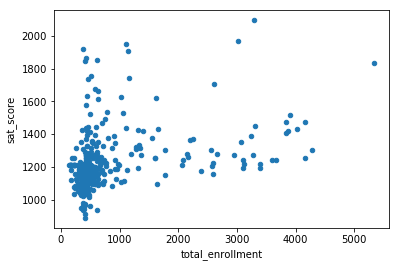

In [24]:
combined.plot.scatter(x='total_enrollment', y='sat_score')
plt.show()

In [25]:
combined_small = combined[combined['total_enrollment'] < 1000]
low_enrollment = combined_small[combined_small['sat_score'] < 1000]
print(low_enrollment['SCHOOL NAME'])
low_enrollment

91                  INTERNATIONAL COMMUNITY HIGH SCHOOL
125                 ACADEMY FOR LANGUAGE AND TECHNOLOGY
126                     BRONX INTERNATIONAL HIGH SCHOOL
139               KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141               INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176    PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
179                       HIGH SCHOOL OF WORLD CULTURES
188                  BROOKLYN INTERNATIONAL HIGH SCHOOL
225       INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS
237                          IT TAKES A VILLAGE ACADEMY
253                           MULTICULTURAL HIGH SCHOOL
286              PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Census Tract,BIN,BBL,NTA,lat,lon,school_dist,AP Test Takers _percent,Total Exams Taken_percent,Number of Exams with scores 3 4 or 5_percent
91,07X334,INTERNATIONAL COMMUNITY HIGH SCHOOL,34,310.0,324.0,311.0,945.0,0,129.028846,197.038462,...,41.0,2000391.0,2.022860e+09,Mott Haven-Port Morris ...,40.810036,-73.917812,07,12.902885,19.703846,15.345000
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,21502.0,2008460.0,2.028660e+09,University Heights-Morris Heights ...,40.849102,-73.916088,09,0.103161,0.103161,0.103161
126,09X403,BRONX INTERNATIONAL HIGH SCHOOL,49,314.0,312.0,339.0,965.0,0,129.028846,197.038462,...,135.0,2004526.0,2.026340e+09,Morrisania-Melrose ...,40.827603,-73.904475,09,1.466237,2.239073,1.743750
139,10X268,KINGSBRIDGE INTERNATIONAL HIGH SCHOOL,52,304.0,356.0,302.0,962.0,Kingsbridge International High School,32.000000,37.000000,...,409.0,2015241.0,2.032470e+09,Van Cortlandt Village ...,40.870377,-73.898163,10,0.271186,0.313559,1.300424
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,409.0,2015241.0,2.032470e+09,Van Cortlandt Village ...,40.870377,-73.898163,10,0.662651,0.879518,0.542169
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,56.0,2027459.0,2.038640e+09,West Farms-Bronx River ...,40.831366,-73.878823,12,0.665540,1.016338,0.791506
179,12X550,HIGH SCHOOL OF WORLD CULTURES,42,304.0,323.0,312.0,939.0,0,129.028846,197.038462,...,56.0,2027459.0,2.038640e+09,West Farms-Bronx River ...,40.831366,-73.878823,12,2.481324,3.789201,2.950962
188,13K439,BROOKLYN INTERNATIONAL HIGH SCHOOL,90,305.0,364.0,312.0,981.0,0,129.028846,197.038462,...,15.0,3000216.0,3.001200e+09,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hi...,40.697175,-73.984960,13,1.121990,1.713378,1.334348
225,17K524,INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS,71,287.0,335.0,291.0,913.0,0,129.028846,197.038462,...,213.0,3029686.0,3.011870e+09,Crown Heights South ...,40.670299,-73.961648,17,1.536058,2.345696,1.826786
237,18K563,IT TAKES A VILLAGE ACADEMY,56,313.0,320.0,330.0,963.0,0,129.028846,197.038462,...,936.0,3104598.0,3.047420e+09,Rugby-Remsen Village ...,40.648664,-73.921899,18,32.257212,49.259615,38.362500


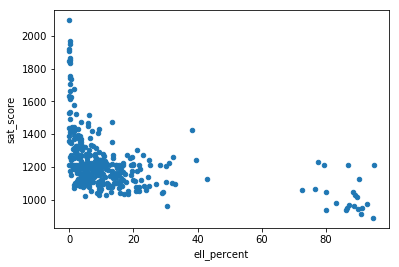

In [26]:
combined.plot.scatter(x='ell_percent', y='sat_score')
plt.show()

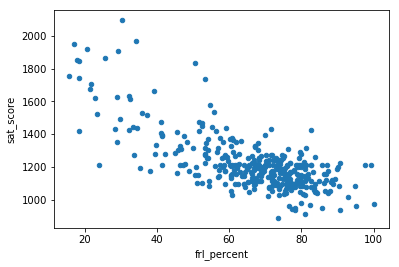

In [27]:
combined.plot.scatter(x='frl_percent', y='sat_score')
plt.show()

/Users/danielzayas/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/danielzayas/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/danielzayas/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


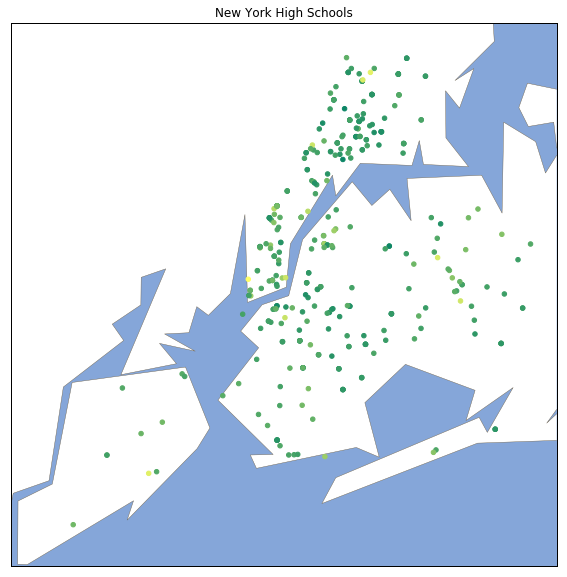

In [71]:
# create a map that centers on New York City
fig, ax = plt.subplots(figsize=(10,10))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

# plot the school locations
latitudes = combined['lat'].tolist()
longitudes = combined['lon'].tolist()
m.scatter(x = longitudes, 
          y = latitudes, 
          latlon=True, # default is False, for passing in axis coordinates
          s=20, # size of the points
          zorder=2, # to plot the points on top of the rest of the map
          cmap = 'summer', # color map
          c = combined['sat_score'], # high % -> green, low % -> yellow
         )
ax.set_title('New York High Schools')
plt.show()

In [29]:
grouped = combined.groupby('school_dist') # grouped by school district
districts = grouped.agg(np.mean) # average values for each column for each school_dist
districts.reset_index(inplace=True) # made school_dist a column and re-indexed the rows
districts

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,Total Grads - n,...,Community Board,Council District,Census Tract,BIN,BBL,lat,lon,AP Test Takers _percent,Total Exams Taken_percent,Number of Exams with scores 3 4 or 5_percent
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,65.500000,...,3.000000,1.500000,1106.833333,1.004144e+06,1.003302e+09,40.719022,-73.982377,1.697941,2.518920,1.805978
1,02,426.210461,443.400188,424.123219,1293.733868,128.908454,201.516827,157.495833,158.647849,121.823630,...,4.204005,2.963296,1132.479744,1.103862e+06,1.070438e+09,40.739699,-73.991386,0.994548,1.493639,1.179579
2,03,427.712589,436.425376,425.496437,1289.634402,156.183494,244.522436,193.087500,183.384409,149.388128,...,7.500000,6.500000,166.666667,1.034931e+06,1.012833e+09,40.781574,-73.977370,0.837987,1.247137,1.217448
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,90.142857,...,11.000000,8.000000,2637.000000,1.055874e+06,1.016681e+09,40.793449,-73.943215,1.337160,1.976281,1.738720
4,05,426.692908,437.338310,418.855107,1282.886325,85.722527,115.725275,142.464286,143.677419,110.919765,...,9.428571,8.142857,9372.571429,1.063080e+06,1.019721e+09,40.817077,-73.949251,0.720459,0.977007,1.222203
5,06,381.685036,399.936817,381.498575,1163.120428,108.711538,159.715385,105.425000,180.848387,128.487671,...,11.179224,10.823823,2765.702770,1.226037e+06,1.170781e+09,40.848970,-73.932502,0.608786,0.902081,0.601055
6,07,376.461538,380.461538,371.923077,1128.846154,73.703402,112.476331,105.276923,105.605459,77.879874,...,1.692308,12.846154,58.538462,2.032562e+06,2.024050e+09,40.816815,-73.919971,1.711329,2.616514,2.140817
7,08,385.322824,393.827683,376.359750,1155.510257,118.379371,168.020979,144.731818,215.510264,119.241594,...,7.272727,16.727273,67.909091,2.037043e+06,2.036723e+09,40.823803,-73.866087,0.652979,0.969714,1.123246
8,09,373.592518,383.268409,374.349287,1131.210214,71.411538,104.265385,98.470000,113.330645,78.282877,...,3.550000,15.750000,5243.750000,2.022457e+06,2.027913e+09,40.836349,-73.906240,0.770279,1.139208,0.998822
9,10,403.363636,418.000000,400.863636,1222.227273,132.231206,226.914336,191.618182,161.318182,118.691781,...,7.000000,12.227273,1686.045455,1.856268e+06,1.850558e+09,40.870345,-73.898360,3.626381,5.570346,4.481425


/Users/danielzayas/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/danielzayas/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/danielzayas/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


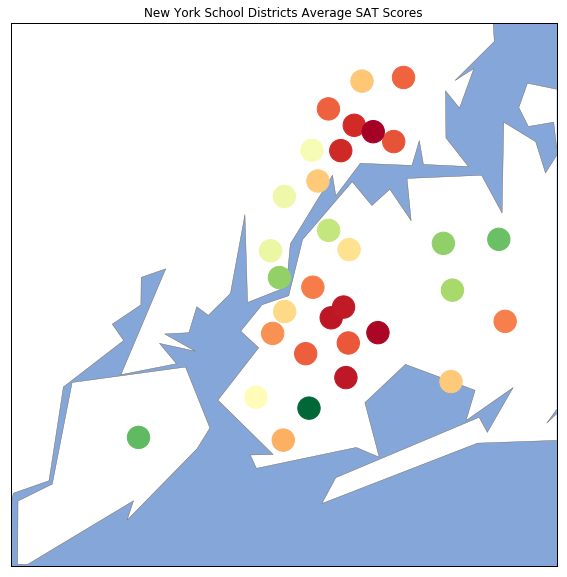

In [85]:
# create a map that centers on New York City
fig, ax = plt.subplots(figsize=(10,10))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')


# plot the school locations
latitudes = districts['lat'].tolist()
longitudes = districts['lon'].tolist()
m.scatter(x = longitudes, 
          y = latitudes, 
          latlon=True, # default is False, for passing in axis coordinates
          s=500, # size of the points
          zorder=2, # to plot the points on top of the rest of the map
          cmap = 'RdYlGn', # color map
          c = districts['sat_score'], # high % -> green, low % -> red
         )
ax.set_title('New York School Districts Average SAT Scores')
plt.show()

/Users/danielzayas/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/danielzayas/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/danielzayas/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


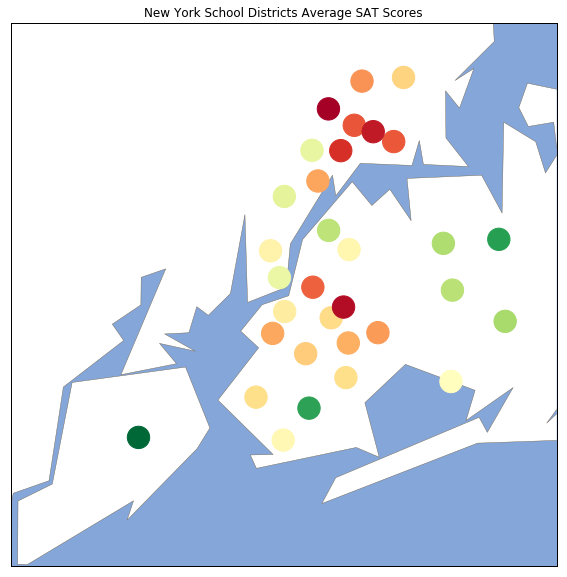

In [84]:
# create a map that centers on New York City
fig, ax = plt.subplots(figsize=(10,10))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')


# plot the school locations
latitudes = districts['lat'].tolist()
longitudes = districts['lon'].tolist()
m.scatter(x = longitudes, 
          y = latitudes, 
          latlon=True, # default is False, for passing in axis coordinates
          s=500, # size of the points
          zorder=2, # to plot the points on top of the rest of the map
          cmap = 'RdYlGn_r', # color map
          c = districts['frl_percent'], # high % -> green, low % -> yellow
         )
ax.set_title('New York School Districts Average SAT Scores')
plt.show()

/Users/danielzayas/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/danielzayas/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/danielzayas/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


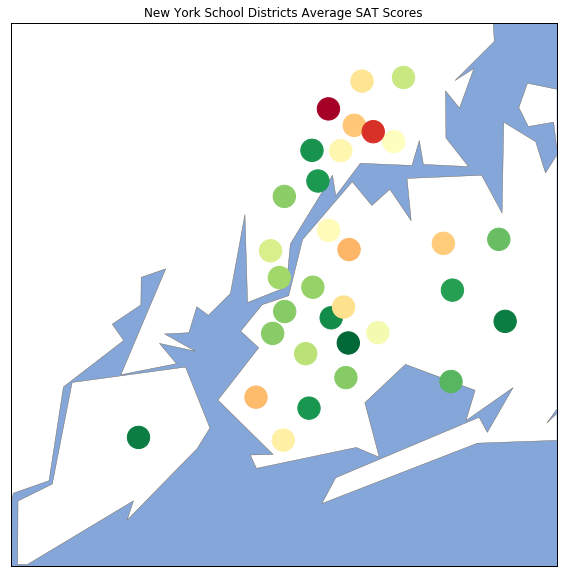

In [91]:
# create a map that centers on New York City
fig, ax = plt.subplots(figsize=(10,10))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')


# plot the school locations
latitudes = districts['lat'].tolist()
longitudes = districts['lon'].tolist()
m.scatter(x = longitudes, 
          y = latitudes, 
          latlon=True, # default is False, for passing in axis coordinates
          s=500, # size of the points
          zorder=2, # to plot the points on top of the rest of the map
          cmap = 'RdYlGn_r', # color map
          c = districts['ell_percent'], # high % -> green, low % -> yellow
         )
ax.set_title('New York School Districts Average SAT Scores')
plt.show()

/Users/danielzayas/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/danielzayas/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/danielzayas/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


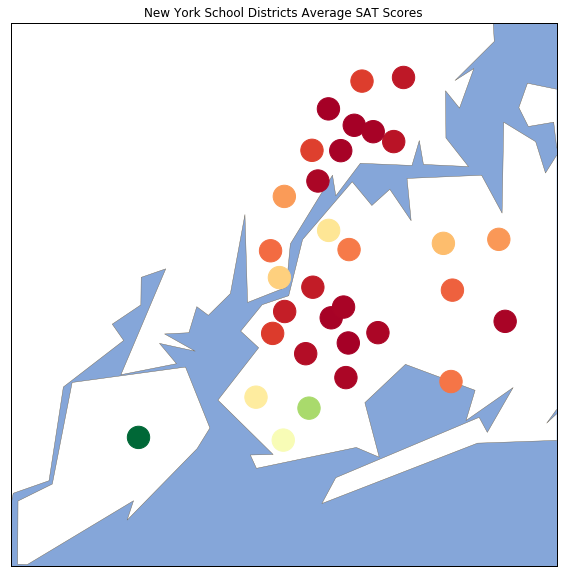

In [90]:
# create a map that centers on New York City
fig, ax = plt.subplots(figsize=(10,10))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')


# plot the school locations
latitudes = districts['lat'].tolist()
longitudes = districts['lon'].tolist()
m.scatter(x = longitudes, 
          y = latitudes, 
          latlon=True, # default is False, for passing in axis coordinates
          s=500, # size of the points
          zorder=2, # to plot the points on top of the rest of the map
          cmap = 'RdYlGn', # color map
          c = districts['white_per'], # high % -> green, low % -> red
         )
ax.set_title('New York School Districts Average SAT Scores')
plt.show()

In [82]:
districts.sort_values('lat', ascending=False)

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,Total Grads - n,...,Community Board,Council District,Census Tract,BIN,BBL,lat,lon,AP Test Takers _percent,Total Exams Taken_percent,Number of Exams with scores 3 4 or 5_percent
10,11,389.866667,394.533333,380.600000,1165.000000,83.813462,122.484615,108.833333,122.866667,82.866667,...,11.466667,12.266667,6469.733333,2.064514e+06,2.046691e+09,40.873138,-73.856120,0.924911,1.366259,1.344227
9,10,403.363636,418.000000,400.863636,1222.227273,132.231206,226.914336,191.618182,161.318182,118.691781,...,7.000000,12.227273,1686.045455,1.856268e+06,1.850558e+09,40.870345,-73.898360,3.626381,5.570346,4.481425
5,06,381.685036,399.936817,381.498575,1163.120428,108.711538,159.715385,105.425000,180.848387,128.487671,...,11.179224,10.823823,2765.702770,1.226037e+06,1.170781e+09,40.848970,-73.932502,0.608786,0.902081,0.601055
8,09,373.592518,383.268409,374.349287,1131.210214,71.411538,104.265385,98.470000,113.330645,78.282877,...,3.550000,15.750000,5243.750000,2.022457e+06,2.027913e+09,40.836349,-73.906240,0.770279,1.139208,0.998822
11,12,364.225059,378.061362,356.997625,1099.284046,93.102564,139.442308,153.450000,110.467742,85.989726,...,5.083333,17.000000,120.083333,2.024516e+06,2.032603e+09,40.831412,-73.886946,6.168936,9.390384,7.783699
7,08,385.322824,393.827683,376.359750,1155.510257,118.379371,168.020979,144.731818,215.510264,119.241594,...,7.272727,16.727273,67.909091,2.037043e+06,2.036723e+09,40.823803,-73.866087,0.652979,0.969714,1.123246
4,05,426.692908,437.338310,418.855107,1282.886325,85.722527,115.725275,142.464286,143.677419,110.919765,...,9.428571,8.142857,9372.571429,1.063080e+06,1.019721e+09,40.817077,-73.949251,0.720459,0.977007,1.222203
6,07,376.461538,380.461538,371.923077,1128.846154,73.703402,112.476331,105.276923,105.605459,77.879874,...,1.692308,12.846154,58.538462,2.032562e+06,2.024050e+09,40.816815,-73.919971,1.711329,2.616514,2.140817
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,90.142857,...,11.000000,8.000000,2637.000000,1.055874e+06,1.016681e+09,40.793449,-73.943215,1.337160,1.976281,1.738720
2,03,427.712589,436.425376,425.496437,1289.634402,156.183494,244.522436,193.087500,183.384409,149.388128,...,7.500000,6.500000,166.666667,1.034931e+06,1.012833e+09,40.781574,-73.977370,0.837987,1.247137,1.217448


In [86]:
districts.sort_values('sat_score', ascending=False)

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,Total Grads - n,...,Community Board,Council District,Census Tract,BIN,BBL,lat,lon,AP Test Takers _percent,Total Exams Taken_percent,Number of Exams with scores 3 4 or 5_percent
21,22,473.500000,502.750000,474.250000,1450.500000,391.007212,614.509615,370.362500,580.250000,457.250000,...,12.750000,45.000000,633.500000,3.260954e+06,3.071058e+09,40.618285,-73.952288,0.920094,1.436884,0.958155
30,31,457.500000,472.500000,452.500000,1382.500000,228.908654,355.111538,194.435000,450.787097,342.621918,...,1.800000,50.000000,6752.500000,5.093752e+06,5.022487e+09,40.595680,-74.125726,0.790202,1.226020,0.777109
25,26,445.200000,487.600000,444.800000,1377.600000,410.605769,632.407692,392.090000,825.600000,623.000000,...,11.800000,21.600000,28776.600000,4.228215e+06,4.072510e+09,40.748507,-73.759176,0.470194,0.723423,0.463492
24,25,437.250000,483.500000,436.250000,1357.000000,205.260817,279.889423,174.793750,268.733871,176.902397,...,8.000000,21.875000,10598.875000,4.217178e+06,4.058888e+09,40.745414,-73.815558,1.021886,1.452161,0.969982
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,65.500000,...,3.000000,1.500000,1106.833333,1.004144e+06,1.003302e+09,40.719022,-73.982377,1.697941,2.518920,1.805978
27,28,445.050097,464.282228,434.359750,1343.692075,182.010490,273.559441,175.336364,351.214076,274.463263,...,8.727273,25.818182,498.272727,4.336396e+06,4.086008e+09,40.709344,-73.806367,0.628758,0.954781,0.815320
29,30,430.316706,465.263130,429.109528,1324.689364,157.231838,252.123932,115.150000,310.526882,203.937595,...,1.222222,25.111111,52.777778,4.166018e+06,4.004830e+09,40.755398,-73.932306,0.668765,1.025426,0.640250
1,02,426.210461,443.400188,424.123219,1293.733868,128.908454,201.516827,157.495833,158.647849,121.823630,...,4.204005,2.963296,1132.479744,1.103862e+06,1.070438e+09,40.739699,-73.991386,0.994548,1.493639,1.179579
2,03,427.712589,436.425376,425.496437,1289.634402,156.183494,244.522436,193.087500,183.384409,149.388128,...,7.500000,6.500000,166.666667,1.034931e+06,1.012833e+09,40.781574,-73.977370,0.837987,1.247137,1.217448
4,05,426.692908,437.338310,418.855107,1282.886325,85.722527,115.725275,142.464286,143.677419,110.919765,...,9.428571,8.142857,9372.571429,1.063080e+06,1.019721e+09,40.817077,-73.949251,0.720459,0.977007,1.222203


In [83]:
districts['sat_score'].mean()

1226.4895829273407

### Survery

In [31]:
col_names = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]
combined.corr()['sat_score'][col_names]

DBN                NaN
rr_s          0.231167
rr_t         -0.025758
rr_p          0.046043
N_s           0.427105
N_t           0.295414
N_p           0.424863
saf_p_11      0.121346
com_p_11     -0.116739
eng_p_11      0.019988
aca_p_11      0.034574
saf_t_11      0.313923
com_t_11      0.081496
eng_t_11      0.035432
aca_t_11      0.131052
saf_s_11      0.336139
com_s_11      0.182990
eng_s_11      0.211559
aca_s_11      0.338009
saf_tot_11    0.317819
com_tot_11    0.074755
eng_tot_11    0.098189
aca_tot_11    0.189521
Name: sat_score, dtype: float64

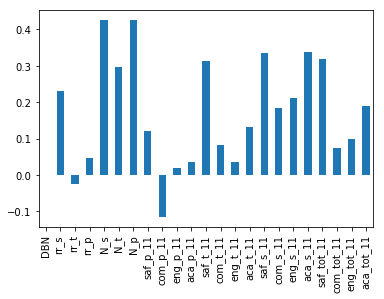

In [32]:
combined.corr()['sat_score'][col_names].plot.bar()
plt.show()

No interesing correlations

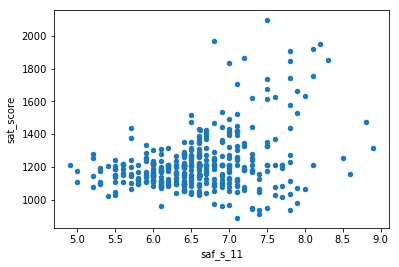

In [40]:
combined.plot.scatter(x = 'saf_s_11', y = 'sat_score')
plt.show()

### Race

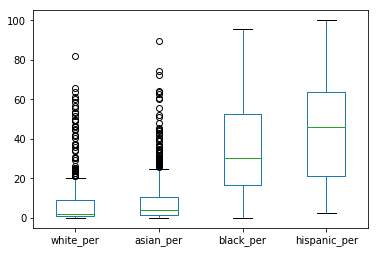

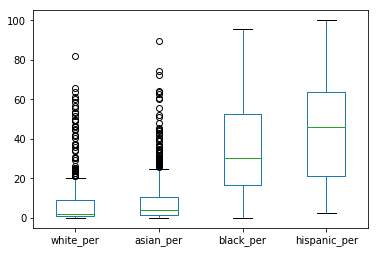

In [54]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined[race_cols].plot.box()
plt.show()

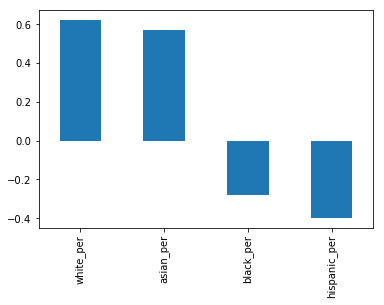

In [57]:
correlations['sat_score'][race_cols].plot.bar()
plt.show()

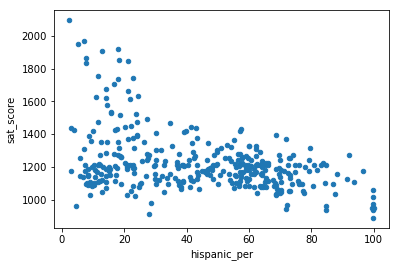

In [61]:
# hispanic
combined.plot.scatter(x = 'hispanic_per', y = 'sat_score')
plt.show()

### Gender

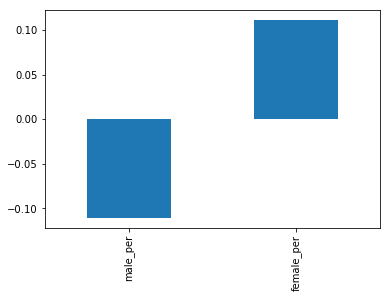

In [62]:
gender_cols = ['male_per', 'female_per']
correlations['sat_score'][gender_cols].plot.bar()
plt.show()

No correlation

### AP Tests

### Class Size

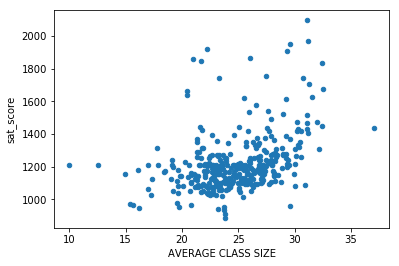

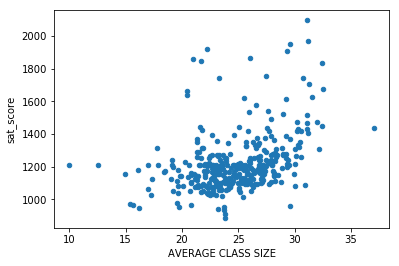

In [64]:
combined.plot.scatter(x = 'AVERAGE CLASS SIZE', y = 'sat_score')
plt.show()

### Graduation

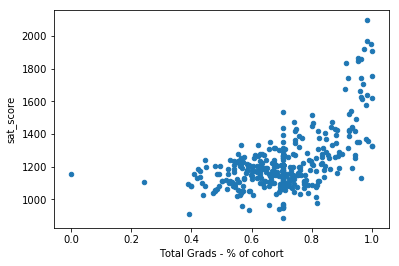

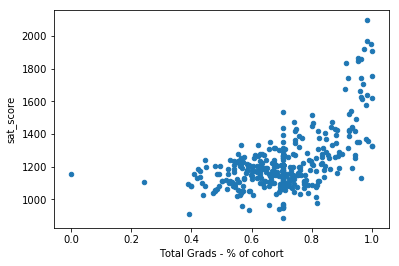

In [66]:
combined.plot.scatter(x = 'Total Grads - % of cohort', y = 'sat_score')
plt.show()

In [67]:
combined[combined['Total Grads - % of cohort'] < .2]


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Census Tract,BIN,BBL,NTA,lat,lon,school_dist,AP Test Takers _percent,Total Exams Taken_percent,Number of Exams with scores 3 4 or 5_percent
228,17K533,SCHOOL FOR DEMOCRACY AND LEADERSHIP,38,377.0,404.0,372.0,1153.0,0,129.028846,197.038462,...,810.0,3107227.0,3.048110e+09,Prospect Lefferts Gardens-Wingate ...,40.659517,-73.942546,17,1.743633,2.662682,2.073649


In [70]:
data['graduation'][data['graduation']['DBN'] == '17K533']

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
1674,Total Cohort,17K533,SCHOOL FOR DEMOCRACY AND LEADERSHIP,2006,74.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,NaN,0.0,0.0,NaN,63.0,0.851,6.0,0.081
